In [1]:
import pandas as pd
import numpy as np
rawdf = pd.read_csv('C:/Users/Brandon Loesch/Desktop/Machine Learning/Project/data/pitch_data_2021.csv')
import matplotlib.pyplot as plt
from matplotlib import cm as CM
from matplotlib import mlab as ML
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [2]:
from time import time

In [3]:
rawdf = rawdf.drop(rawdf.columns[0], axis=1)
rawdf.head()

,pitch_type,release_speed,stand,p_throws,pfx_x,pfx_z,tot_movement,plate_x,plate_z_norm,effective_speed,release_spin_rate,estimated_ba_using_speedangle,estimated_woba_using_speedangle
0,FF,92.3,R,L,-8.28,16.56,18.514643,-0.69,1.02,92.8,2330.0,0.174,0.158
1,FF,91.2,L,L,-7.56,15.36,17.119673,-0.31,0.91,90.9,2281.0,0.100,0.090
2,SI,94.3,R,R,16.20,10.56,19.337880,-0.26,-0.07,94.4,1982.0,0.000,0.000
3,SL,90.5,L,R,-0.12,7.44,7.440968,0.01,0.45,91.1,2133.0,0.409,0.457
4,FF,94.9,R,R,9.00,14.16,16.778129,-0.10,0.10,95.5,2224.0,0.109,0.156


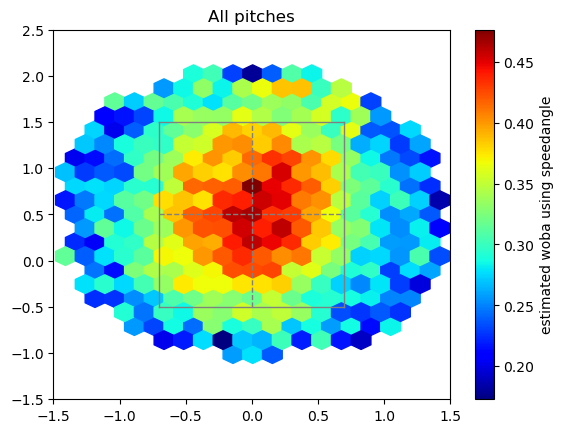

In [5]:
x = rawdf['plate_x']
y = rawdf['plate_z_norm']
C = rawdf['estimated_woba_using_speedangle']
plt.title('All pitches')

#plot strikezone edges
plt.axvline(x = 0, ymin=.25, ymax=.75, color = 'gray', linewidth=1, linestyle='--') 
plt.axvline(x = -0.7, ymin=.25, ymax=.75, color = 'gray', linewidth=1, linestyle='-') 
plt.axvline(x = 0.7, ymin=.25, ymax=.75, color = 'gray', linewidth=1, linestyle='-') 

plt.axhline(y = 0.5, xmin=.267, xmax=0.733, color = 'gray', linewidth=1, linestyle='--')
plt.axhline(y = -.5, xmin=.267, xmax=0.733, color = 'gray', linewidth=1, linestyle='-')
plt.axhline(y = 1.5 , xmin=.267, xmax=0.733, color = 'gray', linewidth=1, linestyle='-')

plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 2.5)

plt.hexbin( x , y , C, gridsize = 30, mincnt = 25, cmap = CM.jet)
cb = plt.colorbar()
cb.set_label('estimated woba using speedangle')
plt.show()

Let's take a look at how many pitches have been thrown for each pitch type:

In [6]:
rawdf.pitch_type.value_counts()

FF    40644
SI    22120
SL    20352
CH    15903
FC     8927
CU     7768
KC     2202
FS     1852
ST     1223
SV      372
FA      219
CS       28
EP       28
KN       15
SC        1
Name: pitch_type, dtype: int64

In [7]:
#drop rare pitches from the analysis
rawdf.drop(rawdf[rawdf['pitch_type'] == 'ST'].index, inplace=True)
rawdf.drop(rawdf[rawdf['pitch_type'] == 'SV'].index, inplace=True)
rawdf.drop(rawdf[rawdf['pitch_type'] == 'FA'].index, inplace=True)
rawdf.drop(rawdf[rawdf['pitch_type'] == 'CS'].index, inplace=True)
rawdf.drop(rawdf[rawdf['pitch_type'] == 'EP'].index, inplace=True)
rawdf.drop(rawdf[rawdf['pitch_type'] == 'KN'].index, inplace=True)
rawdf.drop(rawdf[rawdf['pitch_type'] == 'SC'].index, inplace=True)

In [8]:
rawdf = rawdf.dropna()
rawdf

,pitch_type,release_speed,stand,p_throws,pfx_x,pfx_z,tot_movement,plate_x,plate_z_norm,effective_speed,release_spin_rate,estimated_ba_using_speedangle,estimated_woba_using_speedangle
0,FF,92.3,R,L,-8.28,16.56,18.514643,-0.69,1.02,92.8,2330.0,0.174,0.158
1,FF,91.2,L,L,-7.56,15.36,17.119673,-0.31,0.91,90.9,2281.0,0.100,0.090
2,SI,94.3,R,R,16.20,10.56,19.337880,-0.26,-0.07,94.4,1982.0,0.000,0.000
3,SL,90.5,L,R,-0.12,7.44,7.440968,0.01,0.45,91.1,2133.0,0.409,0.457
4,FF,94.9,R,R,9.00,14.16,16.778129,-0.10,0.10,95.5,2224.0,0.109,0.156
...,...,...,...,...,...,...,...,...,...,...,...,...,...
121702,FF,91.2,L,L,0.36,16.56,16.563913,-0.74,1.11,92.1,2535.0,0.094,0.091
121703,FF,97.1,L,R,3.12,8.64,9.186076,-0.05,0.49,96.8,2233.0,0.071,0.064
121704,SI,95.8,R,R,13.20,5.64,14.354428,0.09,-0.93,94.5,2207.0,0.229,0.211
121705,FF,96.2,L,R,2.88,9.48,9.907815,-0.15,0.57,95.4,2165.0,0.577,0.519


In [9]:
#convert to dummies
type_dum = pd.get_dummies(rawdf.pitch_type)
stand_dum = pd.get_dummies(rawdf.stand)
throws_dum = pd.get_dummies(rawdf.p_throws)
mergedum = pd.concat([rawdf, type_dum, stand_dum, throws_dum], axis='columns')
all_clean = mergedum.drop(['pitch_type', 'stand', 'p_throws'], axis='columns')

all_clean.columns = ['release_speed', 'pfx_x', 'pfx_z', 'tot_movement',
       'plate_x', 'plate_z_norm', 'effective_speed', 'release_spin_rate',
       'estimated_ba_using_speedangle', 'estimated_woba_using_speedangle', 'CH', 'CU','FC', 'FF', 'FS', 'KC','SI', 'SL', 'Batter_L',
       'Batter_R', 'Pitcher_L', 'Pitcher_R']
all_clean = all_clean.dropna()
all_clean.head()

,release_speed,pfx_x,pfx_z,tot_movement,plate_x,plate_z_norm,effective_speed,release_spin_rate,estimated_ba_using_speedangle,estimated_woba_using_speedangle,...,FC,FF,FS,KC,SI,SL,Batter_L,Batter_R,Pitcher_L,Pitcher_R
0,92.3,-8.28,16.56,18.514643,-0.69,1.02,92.8,2330.0,0.174,0.158,...,0,1,0,0,0,0,0,1,1,0
1,91.2,-7.56,15.36,17.119673,-0.31,0.91,90.9,2281.0,0.100,0.090,...,0,1,0,0,0,0,1,0,1,0
2,94.3,16.20,10.56,19.337880,-0.26,-0.07,94.4,1982.0,0.000,0.000,...,0,0,0,0,1,0,0,1,0,1
3,90.5,-0.12,7.44,7.440968,0.01,0.45,91.1,2133.0,0.409,0.457,...,0,0,0,0,0,1,1,0,0,1
4,94.9,9.00,14.16,16.778129,-0.10,0.10,95.5,2224.0,0.109,0.156,...,0,1,0,0,0,0,0,1,0,1


We should split our pitch types into 3 groups and model them seperately - specifically primary pitches, breaking balls and offspeed. What makes a great primary pitch is much different than what makes a great breaking ball.

Also object datatypes need to be converted to dummies.

In [10]:
ff_df = rawdf.loc[rawdf['pitch_type'] == 'FF'] 
si_df = rawdf.loc[rawdf['pitch_type'] == 'SI']

primary_df = pd.concat([ff_df, si_df], axis=0)

type_dum = pd.get_dummies(primary_df.pitch_type)
stand_dum = pd.get_dummies(primary_df.stand)
throws_dum = pd.get_dummies(primary_df.p_throws)
mergedum = pd.concat([primary_df, type_dum, stand_dum, throws_dum], axis='columns')
primary_clean = mergedum.drop(['pitch_type', 'stand', 'p_throws'], axis='columns')

primary_clean.columns = ['release_speed', 'pfx_x', 'pfx_z', 'tot_movement',
       'plate_x', 'plate_z_norm', 'effective_speed', 'release_spin_rate',
       'estimated_ba_using_speedangle', 'estimated_woba_using_speedangle', 'FF', 'SI', 'Batter_L',
       'Batter_R', 'Pitcher_L', 'Pitcher_R']
primary_clean = primary_clean.dropna()

In [11]:
sl_df = rawdf.loc[rawdf['pitch_type'] == 'SL']
cu_df = rawdf.loc[rawdf['pitch_type'] == 'CU']
fc_df = rawdf.loc[rawdf['pitch_type'] == 'FC']
kc_df = rawdf.loc[rawdf['pitch_type'] == 'KC']

breaking_df = pd.concat([sl_df, cu_df, fc_df, kc_df], axis=0)

type_dum = pd.get_dummies(breaking_df.pitch_type)
stand_dum = pd.get_dummies(breaking_df.stand)
throws_dum = pd.get_dummies(breaking_df.p_throws)
mergedum = pd.concat([breaking_df, type_dum, stand_dum, throws_dum], axis='columns')
breaking_clean = mergedum.drop(['pitch_type', 'stand', 'p_throws'], axis='columns')
#columns are rearranged to ensure the right pitch type is assigned
breaking_clean.columns = ['release_speed', 'pfx_x', 'pfx_z', 'tot_movement',
       'plate_x', 'plate_z_norm', 'effective_speed', 'release_spin_rate',
       'estimated_ba_using_speedangle', 'estimated_woba_using_speedangle', 'CU', 'FC', 'KC', 'SL', 'Batter_L',
       'Batter_R', 'Pitcher_L', 'Pitcher_R']
breaking_clean = breaking_clean.dropna()

In [12]:
ch_df = rawdf.loc[rawdf['pitch_type'] == 'CH']
fs_df = rawdf.loc[rawdf['pitch_type'] == 'FS']

offspeed_df = pd.concat([ch_df, fs_df], axis=0)

type_dum = pd.get_dummies(offspeed_df.pitch_type)
stand_dum = pd.get_dummies(offspeed_df.stand)
throws_dum = pd.get_dummies(offspeed_df.p_throws)
mergedum = pd.concat([offspeed_df, type_dum, stand_dum, throws_dum], axis='columns')
offspeed_clean = mergedum.drop(['pitch_type', 'stand', 'p_throws'], axis='columns')

offspeed_clean.columns = ['release_speed', 'pfx_x', 'pfx_z', 'tot_movement',
       'plate_x', 'plate_z_norm', 'effective_speed', 'release_spin_rate',
       'estimated_ba_using_speedangle', 'estimated_woba_using_speedangle', 'CH', 'FS', 'Batter_L',
       'Batter_R', 'Pitcher_L', 'Pitcher_R']
offspeed_clean = offspeed_clean.dropna()

In [13]:
df_list = [primary_clean, breaking_clean, offspeed_clean, all_clean]
name_list = ['Primary pitch', 'Breaking ball', 'Offspeed pitch', 'All Pitches']

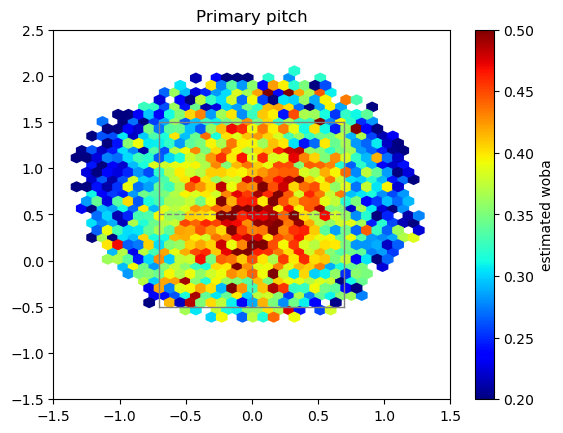

Primary pitch min, mean, max:

Release Speed:  67.6 93.36 102.2
Release Spin Rate:  309.0 2209.89 3563.0
Horizontal Movement:  -24.72 3.9 24.96
Vertical Movement:  -17.4 13.3 26.4 



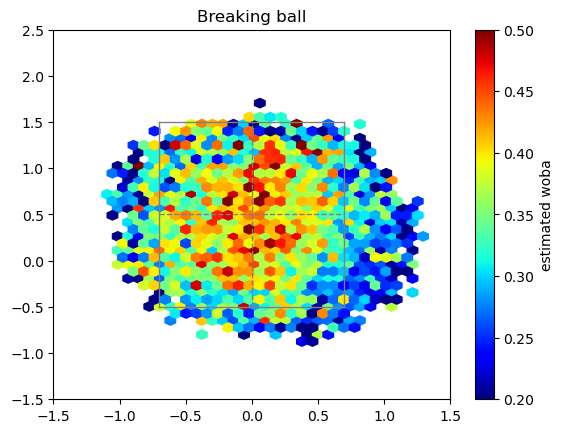

Breaking ball min, mean, max:

Release Speed:  43.6 84.11 102.5
Release Spin Rate:  291.0 2412.8 3722.0
Horizontal Movement:  -25.44 -2.93 25.44
Vertical Movement:  -25.56 0.28 24.48 



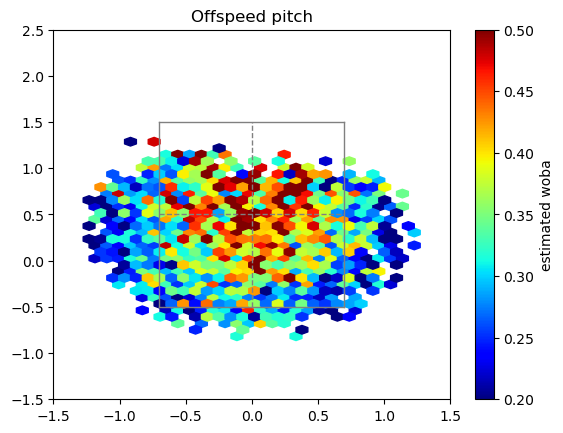

Offspeed pitch min, mean, max:

Release Speed:  55.8 84.77 95.0
Release Spin Rate:  43.0 1707.63 3577.0
Horizontal Movement:  -24.0 3.5 26.16
Vertical Movement:  -13.44 6.63 21.84 



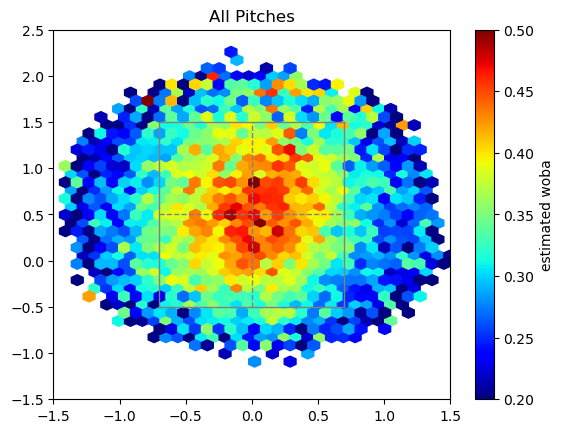

All Pitches min, mean, max:

Release Speed:  43.6 89.05 102.5
Release Spin Rate:  43.0 2201.95 3722.0
Horizontal Movement:  -25.44 1.6 26.16
Vertical Movement:  -25.56 8.04 26.4 



In [14]:
#plot location data for each type of pitch and general information
i=0
for df in df_list:
    
    x = df['plate_x']
    y = df['plate_z_norm']
    C = df['estimated_woba_using_speedangle']
    plt.title(name_list[i])
    plt.axvline(x = 0, ymin=.25, ymax=.75, color = 'gray', linewidth=1, linestyle='--') #ideal strikezone midpoint
    plt.axvline(x = -0.7, ymin=.25, ymax=.75, color = 'gray', linewidth=1, linestyle='-') #strikezone edge left
    plt.axvline(x = 0.7, ymin=.25, ymax=.75, color = 'gray', linewidth=1, linestyle='-') #strikezone edge right

    plt.axhline(y = 0.5, xmin=.267, xmax=0.733, color = 'gray', linewidth=1, linestyle='--')
    plt.axhline(y = -.5, xmin=.267, xmax=0.733, color = 'gray', linewidth=1, linestyle='-')
    plt.axhline(y = 1.5 , xmin=.267, xmax=0.733, color = 'gray', linewidth=1, linestyle='-')
    
    plt.xlim(-1.5, 1.5)
    plt.ylim(-1.5, 2.5)
    
    plt.hexbin( x , y , C, gridsize = 50, mincnt = 10, cmap = CM.jet, vmin=0.2, vmax=0.5)
    
    cb = plt.colorbar()
    cb.set_label('estimated woba')
    plt.show()
    
    print(name_list[i] + ' min, mean, max:\n')
    print('Release Speed: ', df['release_speed'].min(), round(df['release_speed'].mean(),2), df['release_speed'].max())
    print('Release Spin Rate: ', df['release_spin_rate'].min(), round(df['release_spin_rate'].mean(),2), df['release_spin_rate'].max())
    print('Horizontal Movement: ', df['pfx_x'].min(), round(df['pfx_x'].mean(),2), round(df['pfx_x'].max(),2))
    print('Vertical Movement: ', df['pfx_z'].min(), round(df['pfx_z'].mean(),2), round(df['pfx_z'].max(),2), '\n')
    i+=1

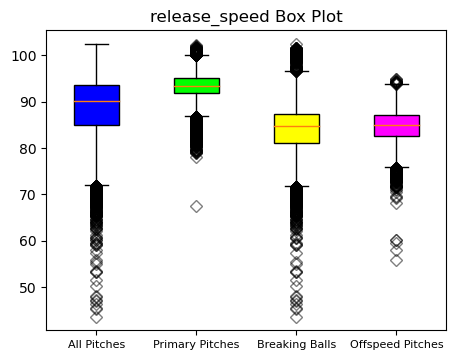

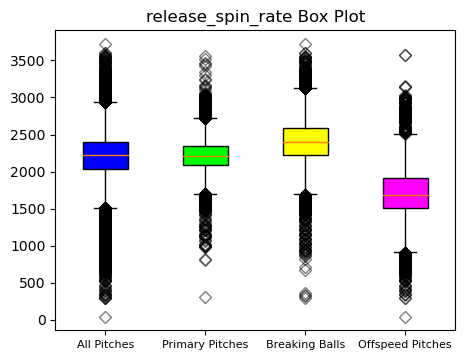

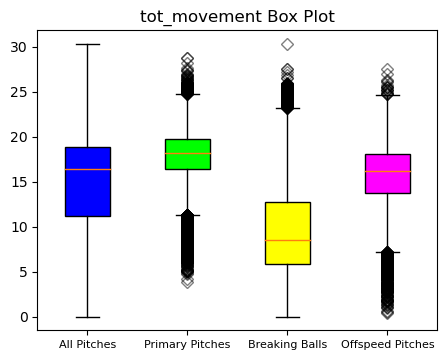

In [15]:
#boxplots
variables = ['release_speed', 'release_spin_rate', 'tot_movement']
for var in variables:
    all_p = all_clean[var]
    prim_p = primary_clean[var]
    break_p = breaking_clean[var]
    off_p = offspeed_clean[var]

    data = [all_p, prim_p, break_p, off_p]

    fig = plt.figure(figsize =(4, 3))

    ax = fig.add_axes([0, 0, 1, 1])

    bp = ax.boxplot(data, patch_artist = True)
    
    colors = ['#0000FF', '#00FF00',
          '#FFFF00', '#FF00FF']
 
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    
    for flier in bp['fliers']:
        flier.set(marker ='D',
              alpha = 0.5)
    
    ax.set_xticklabels(['All Pitches', 'Primary Pitches',
                    'Breaking Balls', 'Offspeed Pitches'], fontsize=8)
    plt.title(var + ' Box Plot')

    plt.show()

XGBoost using hold out test data

Grid Search and feature importance to follow

In [16]:
def compute_impurity_importance(model, title):
    sorted_idx = model.feature_importances_.argsort()
    print(X_train.columns[sorted_idx], '\n', model.feature_importances_[sorted_idx])
    plt.barh(X_train.columns[sorted_idx], model.feature_importances_[sorted_idx])
    plt.xlabel(title, fontsize=11)
    plt.show()

# Method to compute permutation importance (based on test data) and display sorted results
from sklearn.inspection import permutation_importance
def compute_permutation_importance(model, X_test, y_test, rand, title):
    perm_importance = permutation_importance(model, X_test, y_test, random_state=rand)
    sorted_idx = perm_importance.importances_mean.argsort()
    print(X_test.columns[sorted_idx], '\n', perm_importance.importances_mean[sorted_idx])
    plt.barh(X_test.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
    plt.xlabel(title, fontsize=11)
    plt.show()

In [23]:
xgbr = XGBRegressor(booster="gblinear", max_depth=8, gamma=0.5, learning_rate=0.03)

In [24]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV
for i, df in enumerate(df_list):
    print('Results for: ' + name_list[i])
    t0 = time()
    X = df.drop(['estimated_ba_using_speedangle', 'estimated_woba_using_speedangle'], axis='columns')
    y = df['estimated_ba_using_speedangle']

    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    xgbr = XGBRegressor(booster="gblinear", learning_rate=0.03)
    
    from sklearn.model_selection import GridSearchCV
    param_grid = {'n_estimators': np.arange(10,55,5).tolist(),
                 'max_depth':[2,3,4,5,6,7,8,9,10],
                 'gamma': reciprocal(0.0001, 10).rvs(1000).tolist(),
                 'learning_rate': reciprocal(0.0001, 0.03).rvs(1000).tolist()}
    grid_search = RandomizedSearchCV(xgbr, param_grid, n_iter=20, cv=5, scoring="neg_mean_absolute_error")
    grid_search.fit(X, y)
    print('Best score: ' , grid_search.best_score_)
    print('Best params: ' , grid_search.best_params_)
    
    xbgr = XGBRegressor(booster="gblinear", **grid_search.best_params_)
    xgbr.fit(X_train, y_train)
    
    y_train_pred_xgbr = xgbr.predict(X_train)
    print('XGBoost training results:')
    train_rmse_xgbr = np.sqrt(mean_squared_error(y_train, y_train_pred_xgbr))
    train_mae_xgbr = mean_absolute_error(y_train, y_train_pred_xgbr)
    print('RMSE:', train_rmse_xgbr, '\nMAE: ', train_mae_xgbr)

    y_test_pred_xgbr = xgbr.predict(X_test)
    print('XGBoost testing results:')
    test_rmse_xgbr = np.sqrt(mean_squared_error(y_test, y_test_pred_xgbr))
    test_mae_xgbr = mean_absolute_error(y_test, y_test_pred_xgbr)
    print('RMSE:', test_rmse_xgbr, '\nMAE: ', test_mae_xgbr)

    print('\nCoefficients:')
    features = X.columns.tolist()
    for j in range(len(features)):
        print(features[j], ' : ', xgbr.coef_[j])    
    print('\nIntercept: ', xgbr.intercept_)
    print("\nTime to train XGBoost model: %0.3f seconds." % (time() - t0))
    print('\n\n --------------------------------------------------------------- \n\n')

Results for: Primary pitch
Best score:  -0.24847660275534406
Best params:  {'n_estimators': 20, 'max_depth': 7, 'learning_rate': 0.024488232503928436, 'gamma': 0.0590257539219022}
XGBoost training results:
RMSE: 0.28978062990318376 
MAE:  0.24695236271151796
XGBoost testing results:
RMSE: 0.2941445402769712 
MAE:  0.2500199675066223

Coefficients:
release_speed  :  -0.000182504
pfx_x  :  -0.000270006
pfx_z  :  -0.000635383
tot_movement  :  -0.000925375
plate_x  :  0.00872751
plate_z_norm  :  -0.031828
effective_speed  :  -0.000182841
release_spin_rate  :  -7.72018e-06
FF  :  -0.00995698
SI  :  -0.0303362
Batter_L  :  -0.0179892
Batter_R  :  -0.0160659
Pitcher_L  :  -0.0222748
Pitcher_R  :  -0.0149416

Intercept:  [-0.017646]

Time to train XGBoost model: 4.924 seconds.


 --------------------------------------------------------------- 


Results for: Breaking ball
Best score:  -0.24490780582801888
Best params:  {'n_estimators': 35, 'max_depth': 6, 'learning_rate': 0.020916779567247978,

Splitting the pitch types in to different datasets for modeling does not yield better results . From this point onward analysis will be done on the total data, rather than on the categories.

Lets perform XGBoost again on all pitches, and plot how performance improves with n_estimators.

In [25]:
X = all_clean.drop(['estimated_ba_using_speedangle', 'estimated_woba_using_speedangle'], axis='columns')
y = all_clean['estimated_ba_using_speedangle']

xgb.set_config(verbosity=0)
xgbr = XGBRegressor(booster="gblinear", max_depth=8, gamma=0.5, learning_rate=0.03)
param_grid = {'n_estimators': np.arange(10,100).tolist()}
grid_search = GridSearchCV(xgbr, param_grid, cv=5, scoring="neg_mean_absolute_error")
grid_search.fit(X,y)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster='gblinear',
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=0.5, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=0...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=8, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             param_grid={'n_estimators': [10, 11, 12, 13, 14, 15, 16, 17, 18,
                                          19, 20, 21, 22, 23, 24, 25, 26, 27,
                                          28, 29, 30, 31, 32, 33, 34, 35, 36,
                                          37, 38, 39, ...]},
             scoring='neg_mean_absolute_error')

Best: -0.245158 using {'n_estimators': 99}


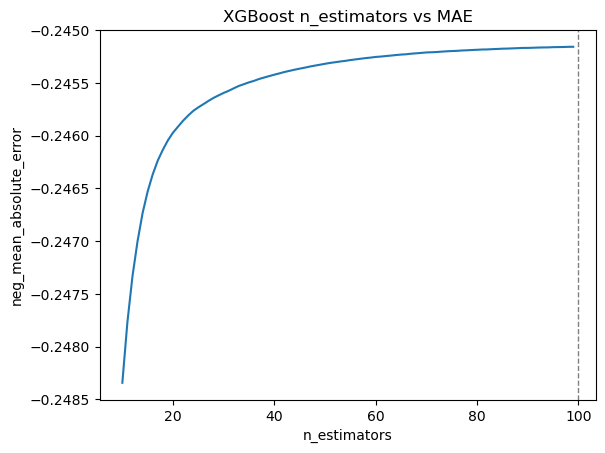

In [27]:
print("Best: %f using %s" % (grid_search.best_score_, grid_search.best_params_))
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
params = grid_search.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))
    
plt.errorbar(np.arange(10,100).tolist(), means)
plt.title("XGBoost n_estimators vs MAE")
plt.xlabel('n_estimators')
plt.ylabel('neg_mean_absolute_error')
plt.axvline(x = 100, color = 'gray', linewidth=1, linestyle='--')

We see here the best number of estimators at max, but performance does not increase much at all passed 20 estimators. Lets do the same thing but with searching for max depth:

In [28]:
xgbr = XGBRegressor(booster="gblinear", n_estimators = 20, gamma=0.5, learning_rate=0.03)
param_grid = {'max_depth': np.arange(2,21).tolist()}
grid_search = GridSearchCV(xgbr, param_grid, cv=5, scoring="neg_mean_absolute_error")
grid_search.fit(X,y)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster='gblinear',
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=0.5, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=0...
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=20,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                       14, 15, 16, 17, 18, 19, 20]},
             scoring='neg_mean_absolute_error')

Best: -0.245965 using {'max_depth': 13}
-0.245974 (0.000505) with: {'max_depth': 2}
-0.245974 (0.000501) with: {'max_depth': 3}
-0.245973 (0.000495) with: {'max_depth': 4}
-0.245980 (0.000508) with: {'max_depth': 5}
-0.245980 (0.000507) with: {'max_depth': 6}
-0.245980 (0.000505) with: {'max_depth': 7}
-0.245970 (0.000501) with: {'max_depth': 8}
-0.245973 (0.000508) with: {'max_depth': 9}
-0.245972 (0.000506) with: {'max_depth': 10}
-0.245973 (0.000502) with: {'max_depth': 11}
-0.245972 (0.000500) with: {'max_depth': 12}
-0.245965 (0.000497) with: {'max_depth': 13}
-0.245973 (0.000506) with: {'max_depth': 14}
-0.245968 (0.000509) with: {'max_depth': 15}
-0.245973 (0.000504) with: {'max_depth': 16}
-0.245971 (0.000505) with: {'max_depth': 17}
-0.245969 (0.000509) with: {'max_depth': 18}
-0.245975 (0.000505) with: {'max_depth': 19}
-0.245971 (0.000503) with: {'max_depth': 20}


Text(0, 0.5, 'neg_mean_absolute_error')

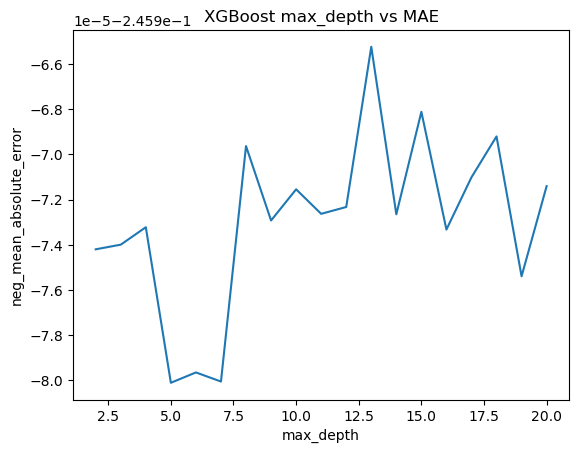

In [29]:
print("Best: %f using %s" % (grid_search.best_score_, grid_search.best_params_))
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
params = grid_search.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
plt.errorbar(np.arange(2,21).tolist(), means)
plt.title("XGBoost max_depth vs MAE")
plt.xlabel('max_depth')
plt.ylabel('neg_mean_absolute_error')

In [30]:
xgbr = XGBRegressor(booster="gblinear", n_estimators = 20, max_depth=3)
param_grid = {'gamma': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4],
             'learning_rate': reciprocal(0.0001, 0.03).rvs(1000).tolist()}
grid_search = RandomizedSearchCV(xgbr, param_grid, n_iter=50, cv=5, scoring="neg_mean_absolute_error")
grid_search.fit(X,y)

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster='gblinear',
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning...
                                                          0.0025744105893422678,
                                                          0.005502648960692729,
                                                          0.0014897168091514454,
                                                          0.00017781735584047894,
                                                          0.0024979497264670317,
                                                          0.012489188228760656,
                                                          0.0020061864170355043,
                                                          0.020567828879898345,
                                                          0.0012176990206452,
                                                          0.0037121815847920175,
                                                          0.000523871339097238,
                                                          0.00019885757800722025,
                                                          0.00020220285642151816,
                                                          0.001152908334745553,
                                                          0.0004771294220169394, ...]},
                   scoring='neg_mean_absolute_error')

In [31]:
print("Best: %f using %s" % (grid_search.best_score_, grid_search.best_params_))
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
params = grid_search.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.246116 using {'learning_rate': 0.0274478239843401, 'gamma': 0.2}
-0.257547 (0.000534) with: {'learning_rate': 0.0071764964542662376, 'gamma': 3.2}
-0.301408 (0.000761) with: {'learning_rate': 0.00012500141538826788, 'gamma': 1.6}
-0.270862 (0.000658) with: {'learning_rate': 0.003566098753088587, 'gamma': 6.4}
-0.246116 (0.000510) with: {'learning_rate': 0.0274478239843401, 'gamma': 0.2}
-0.251877 (0.000507) with: {'learning_rate': 0.010593031540923049, 'gamma': 0.4}
-0.287095 (0.000735) with: {'learning_rate': 0.0013754690558006098, 'gamma': 0.8}
-0.260207 (0.000559) with: {'learning_rate': 0.0061648431586061635, 'gamma': 0.2}
-0.251423 (0.000511) with: {'learning_rate': 0.011012100675065748, 'gamma': 0}
-0.276830 (0.000696) with: {'learning_rate': 0.002613728825805445, 'gamma': 3.2}
-0.287259 (0.000736) with: {'learning_rate': 0.0013585062420420702, 'gamma': 0.2}
-0.296518 (0.000757) with: {'learning_rate': 0.0005072145019092865, 'gamma': 6.4}
-0.284073 (0.000726) with: {'lea

In [32]:
X = all_clean.drop(['estimated_ba_using_speedangle', 'estimated_woba_using_speedangle'], axis='columns')
y = all_clean['estimated_ba_using_speedangle']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

xgbr_optimal = XGBRegressor(booster="gblinear", n_estimators = 20, max_depth=3, gamma=6.4, learning_rate=0.025)
xgbr_optimal.fit(X_train, y_train)

y_train_pred_xgbr = xgbr_optimal.predict(X_train)
print('XGBoost training results:')
train_rmse_xgbr = np.sqrt(mean_squared_error(y_train, y_train_pred_xgbr))
train_mae_xgbr = mean_absolute_error(y_train, y_train_pred_xgbr)
print('RMSE:', train_rmse_xgbr, '\nMAE: ', train_mae_xgbr)

y_test_pred_xgbr = xgbr_optimal.predict(X_test)
print('XGBoost testing results:')
test_rmse_xgbr = np.sqrt(mean_squared_error(y_test, y_test_pred_xgbr))
test_mae_xgbr = mean_absolute_error(y_test, y_test_pred_xgbr)
print('RMSE:', test_rmse_xgbr, '\nMAE: ', test_mae_xgbr)

print('\nCoefficients:')
features = X.columns.tolist()
for j in range(len(features)):
    print(features[j], ' : ', xgbr_optimal.coef_[j])    
print('\nIntercept: ', xgbr_optimal.intercept_)
print('\n\n --------------------------------------------------------------- \n\n')

XGBoost training results:
RMSE: 0.2891666794199235 
MAE:  0.2462436464547125
XGBoost testing results:
RMSE: 0.28895807312377236 
MAE:  0.24621771870626716

Coefficients:
release_speed  :  -0.000228999
pfx_x  :  -6.55516e-05
pfx_z  :  -0.000814214
tot_movement  :  -0.000984883
plate_x  :  -0.000617685
plate_z_norm  :  -0.0153062
effective_speed  :  -0.000228653
release_spin_rate  :  -8.0569e-06
CH  :  -0.0286619
CU  :  -0.0281759
FC  :  -0.0238655
FF  :  -0.0109006
FS  :  -0.0322018
KC  :  -0.0254094
SI  :  -0.0188561
SL  :  -0.0311736
Batter_L  :  -0.0213966
Batter_R  :  -0.0205614
Pitcher_L  :  -0.0208416
Pitcher_R  :  -0.0209139

Intercept:  [-0.0214309]


 --------------------------------------------------------------- 




Index(['release_spin_rate', 'pfx_x', 'effective_speed', 'release_speed',
       'plate_x', 'pfx_z', 'tot_movement', 'FF', 'plate_z_norm', 'SI',
       'Batter_R', 'Pitcher_L', 'Pitcher_R', 'Batter_L', 'FC', 'KC', 'CU',
       'CH', 'SL', 'FS'],
      dtype='object') 
 [2.6748226e-05 2.1762590e-04 7.5910840e-04 7.6025579e-04 2.0506612e-03
 2.7031212e-03 3.2697292e-03 3.6189020e-02 5.0815217e-02 6.2600650e-02
 6.8262160e-02 6.9192201e-02 6.9432281e-02 7.1035013e-02 7.9231486e-02
 8.4357113e-02 9.3541749e-02 9.5154941e-02 1.0349381e-01 1.0690722e-01]


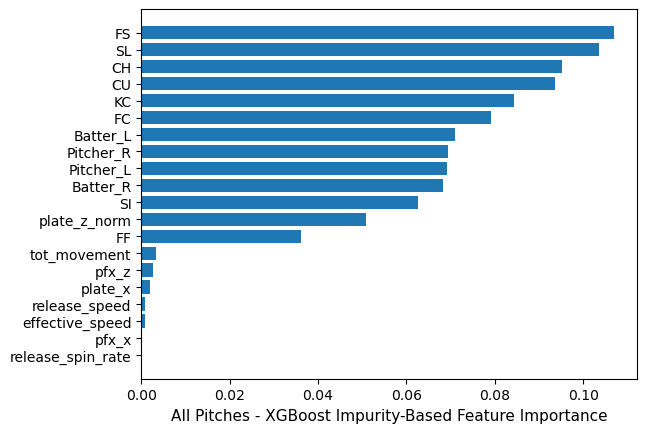

Index(['FF', 'pfx_z', 'release_speed', 'effective_speed', 'tot_movement',
       'pfx_x', 'plate_x', 'release_spin_rate', 'KC', 'SI', 'plate_z_norm',
       'FS', 'FC', 'CU', 'Pitcher_L', 'Batter_R', 'Pitcher_R', 'Batter_L',
       'CH', 'SL'],
      dtype='object') 
 [-1.01698714e-03 -8.77033029e-04 -4.13375623e-04 -3.89868317e-04
 -2.54746478e-04 -6.98405173e-05  1.53528993e-05  1.59573773e-04
  4.63336557e-04  5.75685787e-04  6.66781774e-04  7.81730829e-04
  9.68610334e-04  1.80219272e-03  1.96819511e-03  2.05700303e-03
  2.41342720e-03  3.03829410e-03  3.94934927e-03  5.96357187e-03]


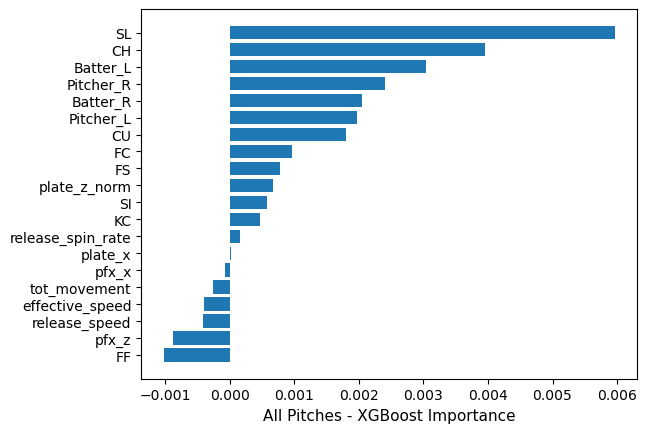

In [33]:
compute_impurity_importance(xgbr_optimal, 'All Pitches - XGBoost Impurity-Based Feature Importance')
compute_permutation_importance(xgbr_optimal, X_test, y_test, 1, 'All Pitches - XGBoost Importance')

Let's test our model on 2022 data now. Justin Verlander's batted balls from the month of June were used for this prediction. This workflow could be fully automated with pybaseball , but for our purpose we will just show an example. Below is the required data modifications required for the prediction to take place.

In [34]:
test_data = pd.read_csv('C:/Users/Brandon Loesch/Desktop/Machine Learning/Project/data/434378_data_2022.csv')
test_data = test_data.drop(test_data.columns[0], axis=1)
test_data.head()

,pitch_type,release_speed,stand,p_throws,pfx_x,pfx_z,tot_movement,plate_x,plate_z_norm,effective_speed,release_spin_rate,estimated_ba_using_speedangle,estimated_woba_using_speedangle
0,FF,95.6,L,R,10.08,17.40,20.108864,0.16,2.035,94.7,2444,0.211,0.427
1,FF,95.3,R,R,8.04,20.40,21.927189,0.05,2.400,94.1,2497,0.209,0.391
2,FF,94.9,L,R,11.04,17.28,20.505609,-0.37,1.825,93.9,2412,0.637,0.604
3,CU,79.4,L,R,-5.04,-15.12,15.937879,-0.21,0.350,78.6,2725,0.069,0.074
4,FF,95.3,R,R,11.76,18.96,22.310966,-0.28,2.500,94.4,2444,0.080,0.072


In [35]:
type_dum = pd.get_dummies(test_data.pitch_type)
stand_dum = pd.get_dummies(test_data.stand)
throws_dum = pd.get_dummies(test_data.p_throws)
mergedum = pd.concat([test_data, type_dum, stand_dum, throws_dum], axis='columns')
test_clean = mergedum.drop(['pitch_type', 'stand', 'p_throws'], axis='columns')

test_clean.columns = ['release_speed', 'pfx_x', 'pfx_z', 'tot_movement',
       'plate_x', 'plate_z_norm', 'effective_speed', 'release_spin_rate',
       'estimated_ba_using_speedangle', 'estimated_woba_using_speedangle', 'CH', 'CU','SL', 'FF', 'Batter_L',
       'Batter_R', 'Pitcher_R']
test_clean = test_clean.dropna()

test_clean

,release_speed,pfx_x,pfx_z,tot_movement,plate_x,plate_z_norm,effective_speed,release_spin_rate,estimated_ba_using_speedangle,estimated_woba_using_speedangle,CH,CU,SL,FF,Batter_L,Batter_R,Pitcher_R
0,95.6,10.08,17.40,20.108864,0.16,2.035,94.7,2444,0.211,0.427,0,0,1,0,1,0,1
1,95.3,8.04,20.40,21.927189,0.05,2.400,94.1,2497,0.209,0.391,0,0,1,0,0,1,1
2,94.9,11.04,17.28,20.505609,-0.37,1.825,93.9,2412,0.637,0.604,0,0,1,0,1,0,1
3,79.4,-5.04,-15.12,15.937879,-0.21,0.350,78.6,2725,0.069,0.074,0,1,0,0,1,0,1
4,95.3,11.76,18.96,22.310966,-0.28,2.500,94.4,2444,0.080,0.072,0,0,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168,96.2,7.92,16.68,18.464799,-0.90,1.625,96.3,2400,0.003,0.003,0,0,1,0,0,1,1
169,90.4,-5.52,6.36,8.421401,0.99,1.735,90.4,2422,0.871,0.829,0,0,0,1,0,1,1
170,95.5,9.36,19.44,21.575987,0.48,1.680,95.3,2359,0.037,0.061,0,0,1,0,0,1,1
171,95.3,14.04,18.24,23.017802,0.16,1.630,95.1,2382,0.346,0.311,0,0,1,0,0,1,1


In [36]:
test_clean['Pitcher_L'] = 0
test_clean['FC'] = 0
test_clean['FS'] = 0
test_clean['KC'] = 0
test_clean['SI'] = 0
test_clean.head()

,release_speed,pfx_x,pfx_z,tot_movement,plate_x,plate_z_norm,effective_speed,release_spin_rate,estimated_ba_using_speedangle,estimated_woba_using_speedangle,...,SL,FF,Batter_L,Batter_R,Pitcher_R,Pitcher_L,FC,FS,KC,SI
0,95.6,10.08,17.40,20.108864,0.16,2.035,94.7,2444,0.211,0.427,...,1,0,1,0,1,0,0,0,0,0
1,95.3,8.04,20.40,21.927189,0.05,2.400,94.1,2497,0.209,0.391,...,1,0,0,1,1,0,0,0,0,0
2,94.9,11.04,17.28,20.505609,-0.37,1.825,93.9,2412,0.637,0.604,...,1,0,1,0,1,0,0,0,0,0
3,79.4,-5.04,-15.12,15.937879,-0.21,0.350,78.6,2725,0.069,0.074,...,0,0,1,0,1,0,0,0,0,0
4,95.3,11.76,18.96,22.310966,-0.28,2.500,94.4,2444,0.080,0.072,...,1,0,0,1,1,0,0,0,0,0


In [37]:
test_clean.columns = ['release_speed', 'pfx_x', 'pfx_z', 'tot_movement',
       'plate_x', 'plate_z_norm', 'effective_speed', 'release_spin_rate',
       'estimated_ba_using_speedangle', 'estimated_woba_using_speedangle', 'CH', 'CU','FC', 'FF', 'FS', 'KC','SI', 'SL', 'Batter_L',
       'Batter_R', 'Pitcher_L', 'Pitcher_R']
test_clean.head()

,release_speed,pfx_x,pfx_z,tot_movement,plate_x,plate_z_norm,effective_speed,release_spin_rate,estimated_ba_using_speedangle,estimated_woba_using_speedangle,...,FC,FF,FS,KC,SI,SL,Batter_L,Batter_R,Pitcher_L,Pitcher_R
0,95.6,10.08,17.40,20.108864,0.16,2.035,94.7,2444,0.211,0.427,...,1,0,1,0,1,0,0,0,0,0
1,95.3,8.04,20.40,21.927189,0.05,2.400,94.1,2497,0.209,0.391,...,1,0,0,1,1,0,0,0,0,0
2,94.9,11.04,17.28,20.505609,-0.37,1.825,93.9,2412,0.637,0.604,...,1,0,1,0,1,0,0,0,0,0
3,79.4,-5.04,-15.12,15.937879,-0.21,0.350,78.6,2725,0.069,0.074,...,0,0,1,0,1,0,0,0,0,0
4,95.3,11.76,18.96,22.310966,-0.28,2.500,94.4,2444,0.080,0.072,...,1,0,0,1,1,0,0,0,0,0


In [38]:
X_2022_test = test_clean.drop(['estimated_ba_using_speedangle', 'estimated_woba_using_speedangle'], axis='columns')
y_2022_test = test_clean['estimated_ba_using_speedangle']

In [39]:
y_test_2022_pred = xgbr_optimal.predict(X_2022_test)
print('XGBoost testing results:')
test_rmse_xgbr = np.sqrt(mean_squared_error(y_2022_test, y_test_2022_pred))
test_mae_xgbr = mean_absolute_error(y_2022_test, y_test_2022_pred)
print('RMSE:', test_rmse_xgbr, '\nMAE: ', test_mae_xgbr)

XGBoost testing results:
RMSE: 0.2639863282724877 
MAE:  0.22451151626509736


In [40]:
for i in range(len(y_2022_test)):
    actual = y_2022_test[i]
    predicted = y_test_2022_pred[i]
    diff = y_2022_test[i]-y_test_2022_pred[i]
    print("Actual: %f, Predicted: %f, Difference: %r" % (actual, predicted, diff))

Actual: 0.211000, Predicted: 0.274529, Difference: -0.06352906966209412
Actual: 0.209000, Predicted: 0.271482, Difference: -0.06248175239562989
Actual: 0.637000, Predicted: 0.278316, Difference: 0.35868424725532533
Actual: 0.069000, Predicted: 0.332942, Difference: -0.2639424560070038
Actual: 0.080000, Predicted: 0.271064, Difference: -0.19106401324272154
Actual: 0.300000, Predicted: 0.282247, Difference: 0.017752903699874867
Actual: 0.063000, Predicted: 0.275604, Difference: -0.21260409903526306
Actual: 0.146000, Predicted: 0.276373, Difference: -0.13037338638305665
Actual: 0.037000, Predicted: 0.265145, Difference: -0.2281452124118805
Actual: 0.069000, Predicted: 0.309021, Difference: -0.24002141332626342
Actual: 0.031000, Predicted: 0.338339, Difference: -0.3073385837078094
Actual: 0.266000, Predicted: 0.326129, Difference: -0.06012901926040648
Actual: 0.031000, Predicted: 0.275692, Difference: -0.24469180727005005
Actual: 0.031000, Predicted: 0.282167, Difference: -0.25116743469238

In [41]:
difference = y_2022_test-y_test_2022_pred
print('Min diff: ',difference.min())
print('Mean diff: ',difference.mean())
print('Max diff: ',difference.max())

Min diff:  -0.33838160943984985
Mean diff:  -0.017186767693888935
Max diff:  0.670226449728012


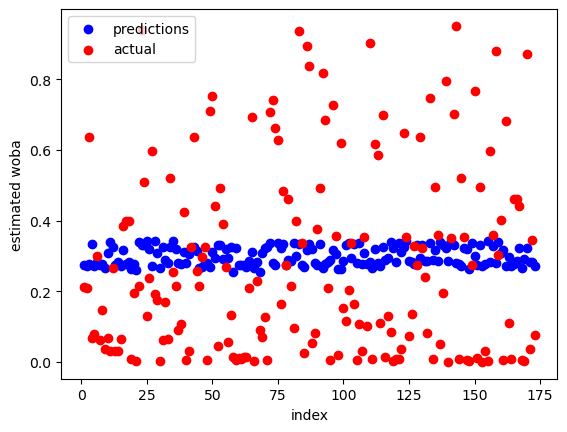

In [42]:
plot_test = y_2022_test
plot_pred = y_test_2022_pred
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(list(range(1,174)), plot_pred, c='b', label='predictions')
ax1.scatter(list(range(1,174)), plot_test, c='r', label='actual')
plt.legend(loc='upper left')
plt.xlabel('index')
plt.ylabel('estimated woba')
plt.show()

Neural Network training

In [487]:
X = all_clean.drop(['estimated_ba_using_speedangle', 'estimated_woba_using_speedangle'], axis='columns')
y = all_clean['estimated_woba_using_speedangle']

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_numeric = X[['release_speed', 'pfx_x', 'pfx_z', 'tot_movement', 'plate_x', 'plate_z_norm', 'effective_speed', 'release_spin_rate']]
X_cat = X[['CH', 'CU','FC', 'FF', 'FS', 'KC','SI', 'SL', 'Batter_L',
       'Batter_R', 'Pitcher_L', 'Pitcher_R']]
scaler.fit(X_numeric)
X_numeric_array = scaler.transform(X_numeric)
X_numeric_df = pd.DataFrame(X_numeric_array, columns=['release_speed', 'pfx_x', 'pfx_z', 'tot_movement', 'plate_x', 'plate_z_norm', 'effective_speed', 'release_spin_rate'])
X_scaled = pd.concat([X_numeric_df.reset_index(drop=True), X_cat.reset_index(drop=True)], axis='columns')

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=1)

In [490]:
np.random.seed(1)
tf.random.set_seed(1)

model = Sequential([
    Dense(100, activation='relu', input_shape=(X_train.shape[1],)), # input neurons = # columns in X_train
    Dense(1)   # of neurons for output layer = 1
])

model.summary()

Model: "sequential_68"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_187 (Dense)           (None, 100)               2100      
                                                                 
 dense_188 (Dense)           (None, 1)                 101       
                                                                 
Total params: 2,201
Trainable params: 2,201
Non-trainable params: 0
_________________________________________________________________


In [491]:
model.compile(loss='mse', metrics=['mae'], optimizer=keras.optimizers.SGD(learning_rate=0.001))
model.optimizer.get_config()

{'name': 'SGD',
 'learning_rate': 0.001,
 'decay': 0.0,
 'momentum': 0.0,
 'nesterov': False}

In [492]:
history = model.fit(X_train, y_train, validation_split=0.1, epochs=10)

Epoch 1/10
2679/2679 [==============================] - 5s 976us/step - loss: 0.1786 - mae: 0.3154 - val_loss: 0.1642 - val_mae: 0.3030
Epoch 2/10
2679/2679 [==============================] - 2s 792us/step - loss: 0.1600 - mae: 0.3007 - val_loss: 0.1600 - val_mae: 0.3038
Epoch 3/10
2679/2679 [==============================] - 2s 817us/step - loss: 0.1569 - mae: 0.2983 - val_loss: 0.1582 - val_mae: 0.2971
Epoch 4/10
2679/2679 [==============================] - 2s 855us/step - loss: 0.1552 - mae: 0.2965 - val_loss: 0.1570 - val_mae: 0.2976
Epoch 5/10
2679/2679 [==============================] - 2s 797us/step - loss: 0.1542 - mae: 0.2955 - val_loss: 0.1564 - val_mae: 0.2969
Epoch 6/10
2679/2679 [==============================] - 2s 819us/step - loss: 0.1535 - mae: 0.2948 - val_loss: 0.1558 - val_mae: 0.2960
Epoch 7/10
2679/2679 [==============================] - 2s 762us/step - loss: 0.1530 - mae: 0.2943 - val_loss: 0.1556 - val_mae: 0.2947
Epoch 8/10
2679/2679 [==========================

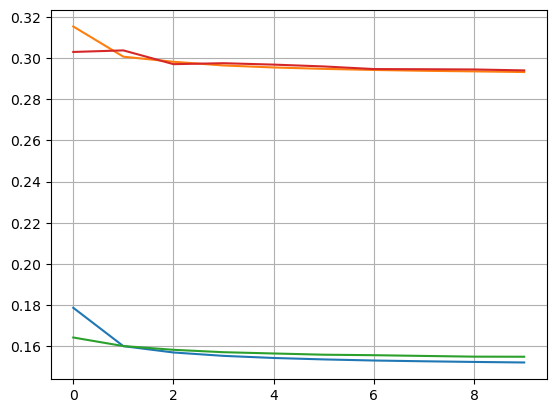

In [493]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(pd.DataFrame(history.history))
plt.grid(True)
plt.show()

In [494]:
print(history.history.keys())
print(history.history)

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])
{'loss': [0.1786278635263443, 0.1599724143743515, 0.1568903625011444, 0.15524592995643616, 0.15421868860721588, 0.15352167189121246, 0.15298578143119812, 0.1526142954826355, 0.15229421854019165, 0.1520310342311859], 'mae': [0.3154161274433136, 0.3007274866104126, 0.29825156927108765, 0.2964562177658081, 0.2954838275909424, 0.294805645942688, 0.29427388310432434, 0.29386988282203674, 0.293582946062088, 0.2932690680027008], 'val_loss': [0.16417454183101654, 0.16000932455062866, 0.15818868577480316, 0.15702460706233978, 0.15640699863433838, 0.15580828487873077, 0.15557315945625305, 0.15521125495433807, 0.15486565232276917, 0.15481913089752197], 'val_mae': [0.30302709341049194, 0.3037841320037842, 0.2970952093601227, 0.29755496978759766, 0.2968686819076538, 0.2959851026535034, 0.29470953345298767, 0.29462429881095886, 0.2945092022418976, 0.29405850172042847]}


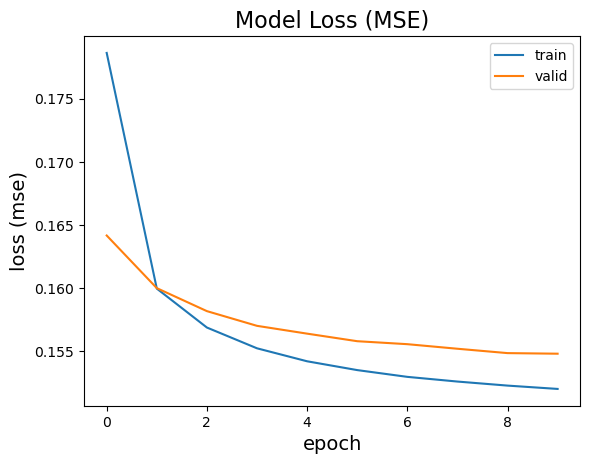

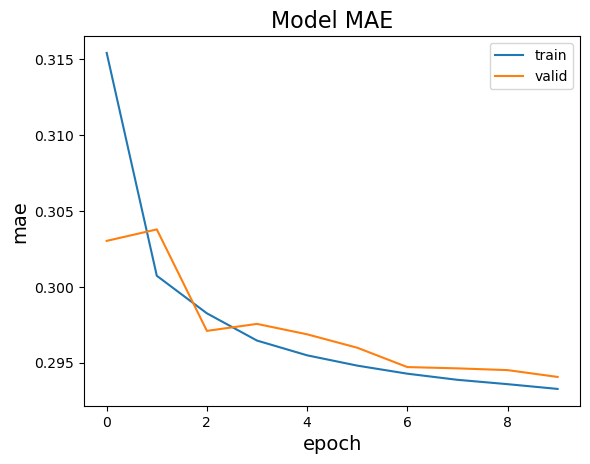

In [495]:
# plot for loss (mse)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss (MSE)', fontsize=16)
plt.xlabel('epoch', fontsize=14)
plt.ylabel('loss (mse)', fontsize=14)
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

# plot for metrics
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model MAE', fontsize=16)
plt.xlabel('epoch', fontsize=14)
plt.ylabel('mae', fontsize=14)
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

In [496]:
# Evaluate NN model using the test set
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
y_test_pred = model.predict(X_test)
print('Test results:')
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
print('RMSE:', test_rmse, '\nMAE: ', test_mae)

745/745 [==============================] - 0s 553us/step
Test results:
RMSE: 0.3905993480569158 
MAE:  0.29246380032372543


In [497]:
print('Test results using evaluate():')
mse, mae = model.evaluate(X_test, y_test)
rmse = np.sqrt(mse)
print('RMSE:', rmse, '\nMAE: ', mae)

Test results using evaluate():
745/745 [==============================] - 1s 667us/step - loss: 0.1526 - mae: 0.2925
RMSE: 0.3905994406921242 
MAE:  0.29246366024017334


In [498]:
np.random.seed(1)
tf.random.set_seed(1)

def build_model(n_hidden=1, n_neurons=10, learning_rate=0.001, input_neurons=(X_train.shape[1],)):
                # initialized parameter values
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_neurons))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
    model.compile(loss="mse", metrics=['mae'], optimizer=optimizer)
    return model

tune_model = keras.wrappers.scikit_learn.KerasRegressor(build_model)

In [499]:
tune_model.fit(X_train, y_train, epochs=20, validation_split=0.1, verbose=0, # suppress each epoch's output
    callbacks=[keras.callbacks.EarlyStopping(patience=10)]) # stop training after 10 epochs with no improvement

In [500]:
y_test_pred = tune_model.predict(X_test)
print('Before tuning test results with early stopping and callbacks:')
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
print('RMSE:', test_rmse, '\nMAE: ', test_mae)

745/745 [==============================] - 0s 555us/step
Before tuning test results with early stopping and callbacks:
RMSE: 0.39196924756893997 
MAE:  0.2947315500058431


In [501]:
np.random.seed(1)
tf.random.set_seed(1)

from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_space = {
    'n_hidden': [0, 1, 2, 3, 4, 5],                                # of hidden layers exhaustive search in [0,1,2,3,4,5] 
    'n_neurons': np.arange(1, 200).tolist(),                 # of neurons per layer exhaustive search in [1,200] 
    'learning_rate': reciprocal(0.0001, 0.03).rvs(1000).tolist() # learning rate random search in (0.0001, 0.03)
}

random_search = RandomizedSearchCV(tune_model, param_space, n_iter=10, cv=5, verbose=1)
random_search.fit(X_train, y_train, epochs=20, validation_split=0.1,
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Epoch 1/20
2143/2143 [==============================] - 2s 1ms/step - loss: 0.1539 - mae: 0.2950 - val_loss: 0.1571 - val_mae: 0.2906
Epoch 2/20
2143/2143 [==============================] - 2s 933us/step - loss: 0.1497 - mae: 0.2916 - val_loss: 0.1547 - val_mae: 0.2974
Epoch 3/20
2143/2143 [==============================] - 2s 945us/step - loss: 0.1489 - mae: 0.2908 - val_loss: 0.1542 - val_mae: 0.2951
Epoch 4/20
2143/2143 [==============================] - 2s 962us/step - loss: 0.1485 - mae: 0.2903 - val_loss: 0.1541 - val_mae: 0.2934
Epoch 5/20
2143/2143 [==============================] - 2s 1ms/step - loss: 0.1482 - mae: 0.2899 - val_loss: 0.1538 - val_mae: 0.2952
Epoch 6/20
2143/2143 [==============================] - 2s 1ms/step - loss: 0.1479 - mae: 0.2896 - val_loss: 0.1539 - val_mae: 0.2917
Epoch 7/20
2143/2143 [==============================] - 2s 961us/step - loss: 0.1477 - mae: 0.2893 - val_loss: 0.1543 - val_mae: 

RandomizedSearchCV(cv=5,
                   estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x000001CC5629FDF0>,
                   param_distributions={'learning_rate': [0.0010789816816471737,
                                                          0.006085988298411347,
                                                          0.0001000652581917702,
                                                          0.0005609374574622059,
                                                          0.00023095753537631243,
                                                          0.00016932999507037909,
                                                          0.0002893271096601813,
                                                          0.0007177873855741621,
                                                          0.0009612606037982739,
                                                          0.002161...
                                                          0.009628117698906266,
                                                          0.025032333105810656,
                                                          0.0005975712481762454,
                                                          0.005187606985571248,
                                                          0.014822525172354476,
                                                          0.016445579472294695,
                                                          0.00016242946863365056,
                                                          0.00012495206379899325,
                                                          0.00026344535281162357,
                                                          0.014971505008038705, ...],
                                        'n_hidden': [0, 1, 2, 3, 4, 5],
                                        'n_neurons': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14, 15,
                                                      16, 17, 18, 19, 20, 21,
                                                      22, 23, 24, 25, 26, 27,
                                                      28, 29, 30, ...]},
                   verbose=1)

In [504]:
print(random_search.best_params_)
print(random_search.best_score_)

{'n_neurons': 183, 'n_hidden': 5, 'learning_rate': 0.007254673873959402}
-0.14981933832168579


In [505]:
y_test_pred = random_search.predict(X_test)
print('After tuning test results with early stopping and callbacks:')
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
print('RMSE:', test_rmse, '\nMAE: ', test_mae)

745/745 [==============================] - 1s 710us/step
After tuning test results with early stopping and callbacks:
RMSE: 0.3871633386210701 
MAE:  0.2933587304379123


In [506]:
print('After tuning test results with early stopping and callbacks, using evaluate():')
mse, mae = best_model.evaluate(X_test, y_test)
rmse = np.sqrt(mse)
print('RMSE:', rmse, '\nMAE: ', mae)

After tuning test results with early stopping and callbacks, using evaluate():
745/745 [==============================] - 1s 694us/step - loss: 0.1589 - mae: 0.2834
RMSE: 0.39859521773609036 
MAE:  0.28336238861083984


In [567]:
optimal_model = keras.models.Sequential()
n_hidden = 5
n_neurons = 183
optimal_model.add(keras.layers.InputLayer(input_shape=X_train.shape[1]))
for layer in range(n_hidden):
        optimal_model.add(keras.layers.Dense(n_neurons, activation="relu"))
optimal_model.add(keras.layers.Dense(1))
optimal_model.summary()

Model: "sequential_130"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_450 (Dense)           (None, 183)               3843      
                                                                 
 dense_451 (Dense)           (None, 183)               33672     
                                                                 
 dense_452 (Dense)           (None, 183)               33672     
                                                                 
 dense_453 (Dense)           (None, 183)               33672     
                                                                 
 dense_454 (Dense)           (None, 183)               33672     
                                                                 
 dense_455 (Dense)           (None, 1)                 184       
                                                                 
Total params: 138,715
Trainable params: 138,715
Non-

In [568]:
#optimal_model.compile(loss='mse', metrics=['mae'], optimizer=keras.optimizers.SGD(learning_rate=0.007254673873959402))
from keras.optimizers import Adam

adam = Adam(lr=0.007254673873959402)

optimal_model.compile(loss='mse', metrics=['mae'], optimizer=adam)
optimal_model.optimizer.get_config()

{'name': 'Adam',
 'learning_rate': 0.007254673873959402,
 'decay': 0.0,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07,
 'amsgrad': False}

In [569]:
optimal_model.get_config()

{'name': 'sequential_130',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 20),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'input_113'}},
  {'class_name': 'Dense',
   'config': {'name': 'dense_450',
    'trainable': True,
    'dtype': 'float32',
    'units': 183,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None}},
  {'class_name': 'Dense',
   'config': {'name': 'dense_451',
    'trainable': True,
    'dtype': 'float32',
    'units': 183,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': None}},
    'bias_initializer': {'class_name': 'Zer

In [570]:
from time import time
t0 = time()
history = optimal_model.fit(X_train, y_train, validation_split=0.1,
                    epochs=100, verbose=0, callbacks=[keras.callbacks.EarlyStopping(patience=10)])  
print("\nTime to train model: %0.3f seconds." % (time() - t0))


Time to train model: 72.260 seconds.


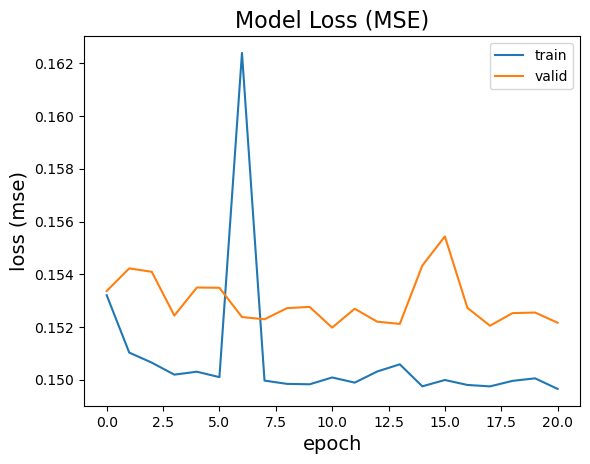

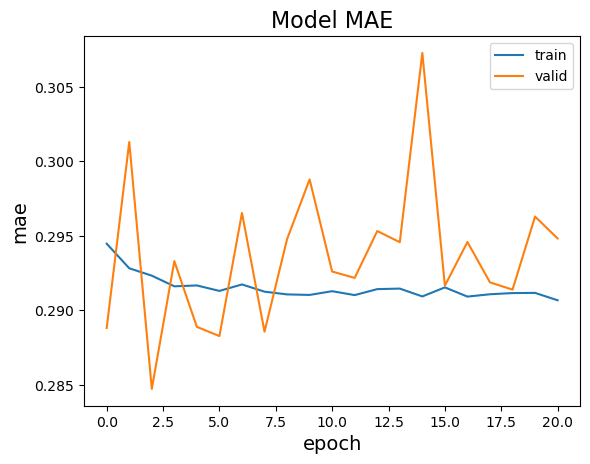

In [571]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss (MSE)', fontsize=16)
plt.xlabel('epoch', fontsize=14)
plt.ylabel('loss (mse)', fontsize=14)
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

# plot for metrics
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model MAE', fontsize=16)
plt.xlabel('epoch', fontsize=14)
plt.ylabel('mae', fontsize=14)
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

In [572]:
for i in range(len(history.history['val_loss'])):
    print(str(i) + ' : ' + str(history.history['val_loss'][i]) + ' , ' + str(history.history['val_mae'][i]))

0 : 0.15336453914642334 , 0.2888123393058777
1 : 0.15422376990318298 , 0.301297664642334
2 : 0.15409253537654877 , 0.28472280502319336
3 : 0.15243414044380188 , 0.29330024123191833
4 : 0.15349754691123962 , 0.2888873815536499
5 : 0.15348772704601288 , 0.28827062249183655
6 : 0.15237802267074585 , 0.2965342104434967
7 : 0.15229366719722748 , 0.2885642349720001
8 : 0.15271639823913574 , 0.29477253556251526
9 : 0.1527627408504486 , 0.2987847626209259
10 : 0.1519773155450821 , 0.29260239005088806
11 : 0.15269222855567932 , 0.292174369096756
12 : 0.1522023230791092 , 0.29532116651535034
13 : 0.1521177440881729 , 0.29457327723503113
14 : 0.15433035790920258 , 0.30727657675743103
15 : 0.15543432533740997 , 0.2916531264781952
16 : 0.1527261883020401 , 0.29458507895469666
17 : 0.15204952657222748 , 0.2918775677680969
18 : 0.15252622961997986 , 0.29138702154159546
19 : 0.15254944562911987 , 0.29628947377204895
20 : 0.1521630436182022 , 0.2948242127895355


_______________________________________________________________________________________________________________